# Exploratory Data Analysis

In this notebook, we will do some data cleaning on the data we collected previously.

## Data import
We previously stored our databases as pickled files; let us retrieve them!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import requests
from datetime import date
import time

import pickle
import os
import sys
import string
import re
import regex

from JsonCollector import JsonCollector

In [2]:
def save_obj(obj, filename):
    with open(filename + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(filename):
    with open(filename + '.pkl', 'rb') as f:
        return pickle.load(f)

In [3]:
DIR = "C:\\Users\\AzNsAnTaGiN\\DSI\\Projects\\project_3\\data\\"
FILE1 = "theonion"
FILE2 = "nottheonion"
FILE3 = "onionheadlines"

We retrieve the pickled JsonCollector objects, and process them into Pandas DataFrames with a few data fields: `id`, `title`, `score`, and `created_utc`. `id` is the unique identifier Reddit assigns to each post; `title` is the title of each post; `score` is presumably the outward-facing score that Reddit displays; `created_utc` is the time the post was created, in unix time.

At the end of this notebook we save these DataFrames to pickled files for future retrieval.

In [4]:
if not os.path.exists(DIR+FILE1+"_df"):
    theonion = load_obj(DIR+FILE1)
    k = theonion.data.keys()
    v = [v["title"] for v in theonion.data.values()]
    s = [v["score"] for v in theonion.data.values()]
    t = [v["created_utc"] for v in theonion.data.values()]
    X_theonion = pd.DataFrame(data = [k,v,s,t],index=["id", "title","score","created_utc"]).T
    X_theonion["len"] = X_theonion["title"].map(lambda x: len(x))
#     del theonion
    save_obj(X_theonion, DIR+FILE1+"_df")
else:
    X_theonion = load_obj(DIR+FILE1+"_df")

In [5]:
if not os.path.exists(DIR+FILE2+"_df"):
    nottheonion = load_obj(DIR+FILE2)
    k = nottheonion.data.keys()
    v = [v["title"] for v in nottheonion.data.values()]
    s = [v["score"] for v in nottheonion.data.values()]
    t = [v["created_utc"] for v in nottheonion.data.values()]
    X_nottheonion = pd.DataFrame(data = [k,v,s,t],index=["id", "title","score","created_utc"]).T
    X_nottheonion["len"] = X_nottheonion["title"].map(lambda x: len(x))
#     del nottheonion
    save_obj(X_nottheonion, DIR+FILE2+"_df")
else:
    X_nottheonion = load_obj(DIR+FILE2+"_df")

In [6]:
if not os.path.exists(DIR+FILE3+"_df"):
    onionheadlines = load_obj(DIR+FILE3)
    k = onionheadlines.data.keys()
    v = [v["title"] for v in onionheadlines.data.values()]
    s = [v["score"] for v in onionheadlines.data.values()]
    X_onionheadlines = pd.DataFrame(data = [k,v,s],index=["id", "title","score"]).T
    X_onionheadlines["len"] = X_onionheadlines["title"].map(lambda x: len(x))
#     del onionheadlines
    save_obj(X_onionheadlines, DIR+FILE3+"_df")
else:
    X_onionheadlines = load_obj(DIR+FILE3+"_df")

In [7]:
X_theonion_orig = X_theonion.copy()
X_nottheonion_orig = X_nottheonion.copy()

## Data Cleaning
Pushshift picks up posts that were deleted or invalid, and we want to exclude these from our analysis

We have a bunch of metadata; how much of this can we use for cleaning?

In [8]:
# metadata = set()
# for k,v in theonion.data.items():
#     [metadata.add(key) for key in v.keys()]
# for k,v in nottheonion.data.items():
#     [metadata.add(key) for key in v.keys()]
# for k,v in onionheadlines.data.items():
#     [metadata.add(key) for key in v.keys()]
# metadata

In [9]:
# onion_metadata = set()
# for k,v in theonion.data.items():
#     [onion_metadata.add(key) for key in v.keys()]
# onion_metadata

In [10]:
# notonion_metadata = set()
# for k,v in nottheonion.data.items():
#     [notonion_metadata.add(key) for key in v.keys()]
# notonion_metadata

### `/r/theonion`

#### Removing links to non-Onion sources
The onion subreddit only allows links from theonion, clickhole, and apparently youtube.

We're going to be even stricter and only allow the onion.

In [11]:
theonion_filter = [k for k,v in theonion.data.items()
#                    if all([domain not in v["domain"] for domain in ["theonion", "clickhole", "youtube"]])]
                   if all([domain not in v["domain"] for domain in ["theonion"]])]
# display(X_theonion["id"].isin(theonion_filter))

X_theonion = X_theonion[~X_theonion["id"].isin(theonion_filter)].reset_index().drop(columns="index").copy()

The following plot will be recurring: It is a histogram our uncleaned data versus time, where each bin is a time window and each amount is the number of entries we have in that window. We show both `/r/theonion` and `/r/nottheonion`, both before and after we prune entries.

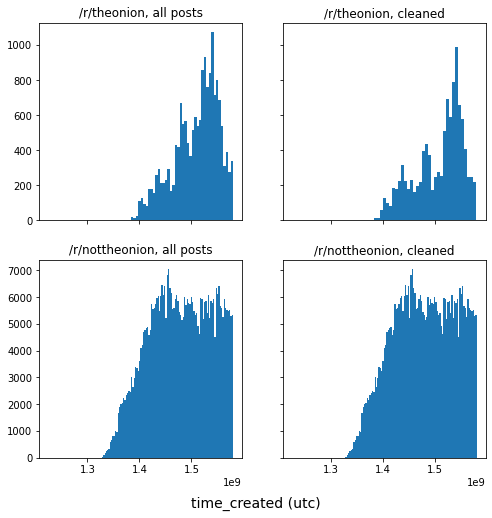

In [12]:
fig, axes = plt.subplots(2,2, figsize=(8,8), sharex=True, sharey="row")
axes = axes.ravel()
axes[0].hist(X_theonion_orig["created_utc"], bins='auto');
axes[1].hist(X_theonion["created_utc"], bins='auto');
axes[2].hist(X_nottheonion_orig["created_utc"], bins='auto');
axes[3].hist(X_nottheonion["created_utc"], bins='auto');

axes[0].set_title('/r/theonion, all posts');
axes[1].set_title('/r/theonion, cleaned');
axes[2].set_title('/r/nottheonion, all posts');
axes[3].set_title('/r/nottheonion, cleaned');

fig.text(0.5, 0.045, 'time_created (utc)', ha='center', va='center', fontsize=14);

#### Removing posts that were removed or were meta

In [13]:
flags = [
#     "is_meta",
#     "is_original_content",
    "removal_reason",
    "removed_by",
    "removed_by_category",
    "quarantine",
    "banned_by",
    "banned_at_utc"
]
theonion_filter = [k for k,v in theonion.data.items()
                   if any([tag in flags for tag in v.keys()])]

In [14]:
X_theonion = X_theonion[~X_theonion["id"].isin(theonion_filter)].reset_index().drop(columns="index").copy()

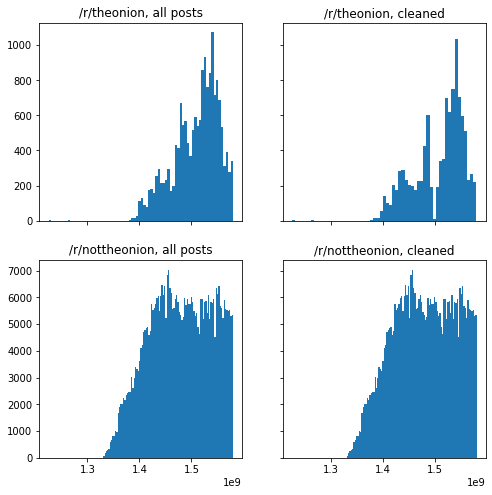

In [15]:
fig, axes = plt.subplots(2,2, figsize=(8,8), sharex=True, sharey="row")
axes = axes.ravel()
axes[0].hist(X_theonion_orig["created_utc"], bins='auto');
axes[1].hist(X_theonion["created_utc"], bins='auto');
axes[2].hist(X_nottheonion_orig["created_utc"], bins='auto');
axes[3].hist(X_nottheonion["created_utc"], bins='auto');

axes[0].set_title('/r/theonion, all posts');
axes[1].set_title('/r/theonion, cleaned');
axes[2].set_title('/r/nottheonion, all posts');
axes[3].set_title('/r/nottheonion, cleaned');

#### Preprocessing whitespace
Sometimes posts contain non-space whitespace. Let's fix that:

In [16]:
X_theonion["title"] = X_theonion["title"].map(lambda x: " ".join(x.split()))

#### Preprocessing Unicode
Sometimes posts contain non-ascii chars. While we'd like to remove them, we ultimately deemed it not worth our time. Our attempts are below:

In [17]:
def isEnglish(s):
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True

In [18]:
with pd.option_context("display.max_colwidth", -1, "display.max_rows", None):
    display(X_nottheonion[~X_nottheonion["title"].map(lambda x: isEnglish(x))].sample(10))

,id,title,score,created_utc,len
108913,36hbgq,Greggs – a bakery – has actually stopped selling loaves of bread,1,1432036021,64
413759,cvn7zu,Wolfenstein developers are “incredibly disappointed” that fighting Nazis is now “problematic”,650,1566821468,93
87628,2tzdc3,Kenny G Says He’s Responsible For The Starbucks Frappuccino,0,1422466360,59
339929,95sjtw,"Christopher Robin, denied Chinese release, is the latest victim in China’s war on Winnie the Pooh",1,1533781813,97
42003,21avtq,Atheist ‘Noah’ director brags film is least biblical Bible movie ever,208,1395727573,69
148688,3ueijr,‘Mister Ugly’ contest sparks riot after fans claim winner is ‘too handsome’,0,1448579938,75
355172,9sgzn0,Ohio haunted house apologizes for hosting ‘Swastika Saturday’ event hours after Synagogue shooting.,1,1540845340,99
133824,3lrtyt,Chea &amp; Chhong busted over B’bang pot farms,1,1442815816,46
202396,4xz1b0,Japanese pole vaulter’s Olympic dream crushed by his own penis,1,1471347385,62
414865,cyophu,Harry Potter books removed from school library to due to concerns over ‘real’ spells and curses,1,1567429474,95


In [19]:
# # X_theonion["title"]
# X_theonion["title"].map(lambda x: regex.sub(u'[^\p{Latin}]&[^w]', u'', x))

In [20]:
X_theonion["title"]

0        Microsoft Ad Campaign Crashing Nation's Televi...
1                Obama's Embarrassing Ska Album Resurfaces
2        Kid Not Getting In Strange Van For Anything Le...
3        Last Thing Government Worker Needed Was Agency...
4        God Cites 'Moving In Mysterious Ways' As Motiv...
                               ...                        
10367    Trump Lifts Obama-Era Protections Trapping Gan...
10368    Eli Manning Retires From NFL To Focus On Being...
10369    Weinstein Defense Attorney Implores Jury To Re...
10370    Melting Giraffe Congressman Warns Impeachment ...
10371    Trump Makes Powerful Pro-Life Case By Speaking...
Name: title, Length: 10372, dtype: object

#### Removing posts that don't have proper titles

In [21]:
# The Onion Headlines Are Almost Always Cased Like This.
# Using this to filter for headlines:
# Only selects entries that ALWAYS capitalize
# the first letter of every word.
X_theonion = X_theonion[
    X_theonion["title"].map(
        lambda x: np.all([
            y[0].isupper()
            for y in re.sub('[^A-Za-z ]+', '', x).split()
]))].copy()

In [22]:
len(X_theonion)

9981

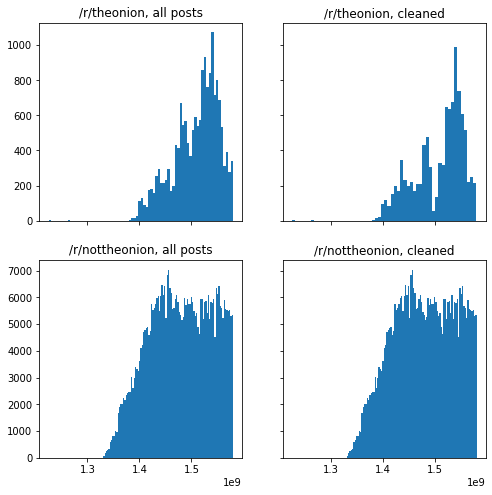

In [23]:
fig, axes = plt.subplots(2,2, figsize=(8,8), sharex=True, sharey="row")
axes = axes.ravel()
axes[0].hist(X_theonion_orig["created_utc"], bins='auto');
axes[1].hist(X_theonion["created_utc"], bins='auto');
axes[2].hist(X_nottheonion_orig["created_utc"], bins='auto');
axes[3].hist(X_nottheonion["created_utc"], bins='auto');

axes[0].set_title('/r/theonion, all posts');
axes[1].set_title('/r/theonion, cleaned');
axes[2].set_title('/r/nottheonion, all posts');
axes[3].set_title('/r/nottheonion, cleaned');

#### Removing non-headlines

Posts often contain substrings like `| The Onion` and `America's Finest News Source`. We'll remove these.

In [24]:
# Remove all crossposts
X_theonion["cleantitle"] = X_theonion["title"].map(lambda x: re.sub('\(|\[x*post*\]|\)', '', x))

In [25]:
# Remove all substrings following a pipe |.
X_theonion["cleantitle"] = X_theonion["cleantitle"].map(lambda x: re.sub('\|(.*)', '', x))

In [26]:
# I honestly don't even remember what this one does
# but I think it removes bracketted terms
X_theonion["cleantitle"] = X_theonion["cleantitle"].map(lambda x: re.sub("\[(.*)\]",'',x))

In [27]:
substrings_to_remove = [
    " \| The Onion - America's Finest News Source",
    " - The Onion - America's Finest News Source",
    " - America's Finest News Source",
    " \| The Onion",
    "\| Video",
    "Video: ",
    " - Video",
    " \[Video\]",
    " \[2011 Video\]",
    "Article: ",
    " \(Article\)",
    "\(Onion Article\)",
    "The Onion's",
    "The Onion’s",
    "‘The Onion’",
    "The Onion",
    "Onion ",
    " \| ClickHole",
    "American Voices: ",
    "American Voices : ",
    "American Voices - ",
    "American Voices; ",
    "’",
    "‘",
    "'",
]

In [28]:
for s in substrings_to_remove:
    X_theonion["cleantitle"] = X_theonion["cleantitle"].str.replace(s, "")
X_theonion["cleanlen"] = X_theonion["cleantitle"].map(lambda x: len(x))
X_theonion["clean_word_len"] = X_theonion["cleantitle"].map(lambda x: x.count(" "))
X_theonion = X_theonion[X_theonion["clean_word_len"]>=3].copy()

In [29]:
# with pd.option_context("display.max_colwidth", -1, "display.max_rows", None):
#     display(X_theonion[X_theonion["clean_word_len"].between(3,4)])

#### Removing duplicates

In [30]:
X_theonion = X_theonion.drop_duplicates(subset="cleantitle").copy()

In [31]:
X_theonion

,id,title,score,created_utc,len,cleantitle,cleanlen,clean_word_len
0,79mcv,Microsoft Ad Campaign Crashing Nation's Televi...,5,1225117091,52,Microsoft Ad Campaign Crashing Nations Televis...,50,5
1,b4qfd,Obama's Embarrassing Ska Album Resurfaces,1,1266782395,41,Obamas Embarrassing Ska Album Resurfaces,40,4
2,1noybe,Kid Not Getting In Strange Van For Anything Le...,26,1380847139,67,Kid Not Getting In Strange Van For Anything Le...,67,11
3,1nozfs,Last Thing Government Worker Needed Was Agency...,8,1380848039,74,Last Thing Government Worker Needed Was Agency...,72,9
4,1nsllw,God Cites 'Moving In Mysterious Ways' As Motiv...,12,1380994431,86,God Cites Moving In Mysterious Ways As Motive ...,84,14
...,...,...,...,...,...,...,...,...
10367,et718z,Trump Lifts Obama-Era Protections Trapping Gan...,1,1579850473,116,Trump Lifts Obama-Era Protections Trapping Gan...,116,16
10368,etdrvf,Eli Manning Retires From NFL To Focus On Being...,1,1579887928,75,Eli Manning Retires From NFL To Focus On Being...,75,11
10369,etgbfu,Weinstein Defense Attorney Implores Jury To Re...,1,1579898672,78,Weinstein Defense Attorney Implores Jury To Re...,76,11
10370,ethb4e,Melting Giraffe Congressman Warns Impeachment ...,1,1579903022,77,Melting Giraffe Congressman Warns Impeachment ...,77,8


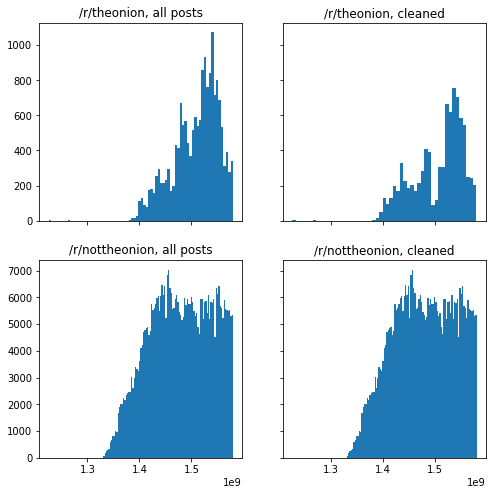

In [32]:
fig, axes = plt.subplots(2,2, figsize=(8,8), sharex=True, sharey="row")
axes = axes.ravel()
axes[0].hist(X_theonion_orig["created_utc"], bins='auto');
axes[1].hist(X_theonion["created_utc"], bins='auto');
axes[2].hist(X_nottheonion_orig["created_utc"], bins='auto');
axes[3].hist(X_nottheonion["created_utc"], bins='auto');

axes[0].set_title('/r/theonion, all posts');
axes[1].set_title('/r/theonion, cleaned');
axes[2].set_title('/r/nottheonion, all posts');
axes[3].set_title('/r/nottheonion, cleaned');

#### Final pass

In [33]:
X_theonion = X_theonion.loc[:,["id","cleantitle","score","created_utc"]].copy()
X_theonion = X_theonion.rename(columns={"cleantitle":"title"}).copy()
X_theonion["len"] = X_theonion["title"].map(lambda x: len(x))
X_theonion["word_len"] = X_theonion["title"].map(lambda x: len(x.split(" ")))

In [34]:
X_theonion.set_index("id", inplace=True)

In [35]:
X_theonion.drop_duplicates(subset="title", inplace=True)

In [36]:
with pd.option_context("display.max_colwidth", -1, "display.max_rows", None):
    display(X_theonion[X_theonion["word_len"]<3])

,title,score,created_utc,len,word_len
id,,,,,


In [37]:
len(X_theonion)

8588

### `/r/nottheonion`

#### Removing bad posts

In [38]:
flags = [
#     "is_meta",
#     "is_original_content",
    "removal_reason",
    "removed_by",
    "removed_by_category",
    "quarantine",
    "banned_by",
    "banned_at_utc"
]
nottheonion_filter = [k for k,v in nottheonion.data.items()
                   if any([tag in flags for tag in v.keys()])]

In [39]:
len(nottheonion_filter)

19469

In [40]:
X_nottheonion_pruned = X_nottheonion[~X_nottheonion["id"].isin(nottheonion_filter)].reset_index().drop(columns="index").copy()

In [41]:
# X_nottheonion_pruned = X_nottheonion.set_index("id").loc[nottheonion_filter].copy().drop_duplicates(subset="title")

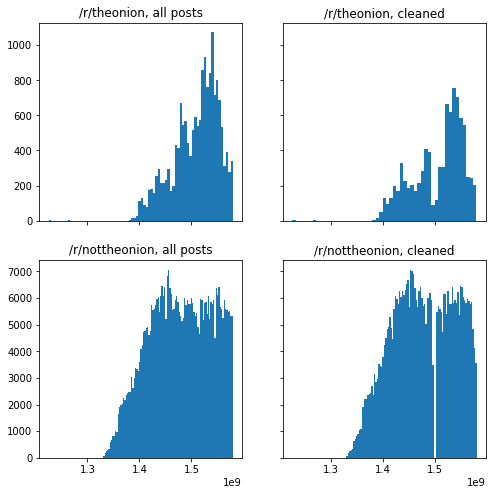

In [42]:
fig, axes = plt.subplots(2,2, figsize=(8,8), sharex=True, sharey="row")
axes = axes.ravel()
axes[0].hist(X_theonion_orig["created_utc"], bins='auto');
axes[1].hist(X_theonion["created_utc"], bins='auto');
axes[2].hist(X_nottheonion_orig["created_utc"], bins='auto');
axes[3].hist(X_nottheonion_pruned["created_utc"], bins='auto');

axes[0].set_title('/r/theonion, all posts');
axes[1].set_title('/r/theonion, cleaned');
axes[2].set_title('/r/nottheonion, all posts');
axes[3].set_title('/r/nottheonion, cleaned');

#### We were originally only going to subsample posts with high scores, but this biases our results (towards times of higher subreddit activity, for example), so we won't do this anymore. To illustrate:

In [43]:
X_nottheonion_pruned2 = X_nottheonion_pruned[X_nottheonion_pruned["score"]>15].copy()
len(X_nottheonion_pruned)

422340

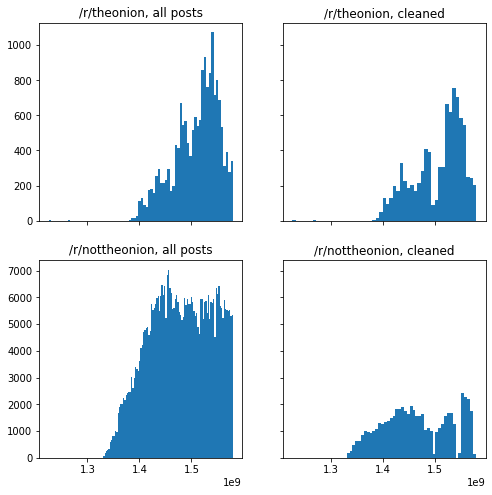

In [44]:
fig, axes = plt.subplots(2,2, figsize=(8,8), sharex=True, sharey="row")
axes = axes.ravel()
axes[0].hist(X_theonion_orig["created_utc"], bins='auto');
axes[1].hist(X_theonion["created_utc"], bins='auto');
axes[2].hist(X_nottheonion_orig["created_utc"], bins='auto');
axes[3].hist(X_nottheonion_pruned2["created_utc"], bins='auto');

axes[0].set_title('/r/theonion, all posts');
axes[1].set_title('/r/theonion, cleaned');
axes[2].set_title('/r/nottheonion, all posts');
axes[3].set_title('/r/nottheonion, cleaned');

In [45]:
with pd.option_context("display.max_colwidth", -1, "display.max_rows", 20):
#     display(X_nottheonion_pruned[X_nottheonion_pruned["score"]>15])
    display(X_nottheonion_pruned.loc[X_nottheonion_pruned["title"].str.contains("LSD")])

,id,title,score,created_utc,len
1116,wxmxn,Teen high on LSD starts fight with a mailbox\n,0,1342898032,45
1240,xbamb,Teen on LSD Arrested for Fighting with a Mailbox (X-post /r/offbeat),20,1343510413,68
7360,1878uk,LSD 'helps alcoholics to give up drinking',17,1360432622,42
10798,1bnsmo,"Tot, 3, ate mother's LSD sugar",13,1365084258,30
12393,1d5wp5,LSD-tripping Florida man claims to be God and asks police to cut off his penis,18,1366995602,78
...,...,...,...,...,...
403918,d8hiu1,"Disneyland Paris visitor on bad LSD trip falls into Adventureland lake, turns up naked after 130-person search",6421,1569295219,110
405313,dc7hs0,Man who took LSD at Disneyland sparks manhunt,2,1570005985,45
408110,diznyk,"TIL that according to Graham Nash, Jimi Hendrix was unbeatable at the game Risk, especially while on LSD.",2,1571277968,105
412591,du6tn8,Synth repairman accidentally gets high after touching old LSD on a vintage ’60s synthesizer,1,1573359780,91


#### Preprocessing whitespace
Sometimes posts contain non-space whitespace. Let's fix that:

In [46]:
X_nottheonion["title"] = X_nottheonion["title"].map(lambda x: " ".join(x.split()))

#### Regex title cleaning.

Patterns we want to excise:
- [x-post*]
- (x-post*)
- X-post from
- xpost
- - video
- – video
- [video]
- (video)
- -news source
- '\n'
- '\t'
- &amp;
- nsfw
- |*
- -[A-Z]

In [47]:
# Remove all xpost headers
X_nottheonion_pruned["cleantitle"] = X_nottheonion_pruned["title"].map(lambda x: re.sub('\(|\[x*post*\]|\)', '', x))

In [48]:
# Remove all substrings following a pipe.
X_nottheonion_pruned["cleantitle"] = X_nottheonion_pruned["cleantitle"].map(lambda x: re.sub('\|(.*)', '', x))

#### Onionize The Titles

In [49]:
# using str.title() turns LSD to Lsd, which is undesirable
# Split by single spaces; capitalize the first letter of each word;
# join them together on a space 
X_nottheonion_pruned["onionized"] = X_nottheonion_pruned["cleantitle"].map(
lambda x: " ".join(["".join(
        [c.upper() if i ==0 else c for i,c in enumerate(word)])
    for word in x.split(" ")]
))


In [50]:
# Do the same thing with hyphens.
X_nottheonion_pruned["onionized"] = X_nottheonion_pruned["onionized"].map(
lambda x: "-".join(["".join(
        [c.upper() if i ==0 else c for i,c in enumerate(word)])
    for word in x.split("-")]
))

In [51]:
with pd.option_context("display.max_colwidth", -1, "display.max_rows", 20):
    display(X_nottheonion_pruned.loc[X_nottheonion_pruned["title"].str.contains("LSD")])

,id,title,score,created_utc,len,cleantitle,onionized
1116,wxmxn,Teen high on LSD starts fight with a mailbox\n,0,1342898032,45,Teen high on LSD starts fight with a mailbox\n,Teen High On LSD Starts Fight With A Mailbox\n
1240,xbamb,Teen on LSD Arrested for Fighting with a Mailbox (X-post /r/offbeat),20,1343510413,68,Teen on LSD Arrested for Fighting with a Mailbox X-post /r/offbeat,Teen On LSD Arrested For Fighting With A Mailbox X-Post /r/offbeat
7360,1878uk,LSD 'helps alcoholics to give up drinking',17,1360432622,42,LSD 'helps alcoholics to give up drinking',LSD 'helps Alcoholics To Give Up Drinking'
10798,1bnsmo,"Tot, 3, ate mother's LSD sugar",13,1365084258,30,"Tot, 3, ate mother's LSD sugar","Tot, 3, Ate Mother's LSD Sugar"
12393,1d5wp5,LSD-tripping Florida man claims to be God and asks police to cut off his penis,18,1366995602,78,LSD-tripping Florida man claims to be God and asks police to cut off his penis,LSD-Tripping Florida Man Claims To Be God And Asks Police To Cut Off His Penis
...,...,...,...,...,...,...,...
403918,d8hiu1,"Disneyland Paris visitor on bad LSD trip falls into Adventureland lake, turns up naked after 130-person search",6421,1569295219,110,"Disneyland Paris visitor on bad LSD trip falls into Adventureland lake, turns up naked after 130-person search","Disneyland Paris Visitor On Bad LSD Trip Falls Into Adventureland Lake, Turns Up Naked After 130-Person Search"
405313,dc7hs0,Man who took LSD at Disneyland sparks manhunt,2,1570005985,45,Man who took LSD at Disneyland sparks manhunt,Man Who Took LSD At Disneyland Sparks Manhunt
408110,diznyk,"TIL that according to Graham Nash, Jimi Hendrix was unbeatable at the game Risk, especially while on LSD.",2,1571277968,105,"TIL that according to Graham Nash, Jimi Hendrix was unbeatable at the game Risk, especially while on LSD.","TIL That According To Graham Nash, Jimi Hendrix Was Unbeatable At The Game Risk, Especially While On LSD."
412591,du6tn8,Synth repairman accidentally gets high after touching old LSD on a vintage ’60s synthesizer,1,1573359780,91,Synth repairman accidentally gets high after touching old LSD on a vintage ’60s synthesizer,Synth Repairman Accidentally Gets High After Touching Old LSD On A Vintage ’60s Synthesizer


In [52]:
# X_nottheonion = 
# X_nottheonion_pruned.loc[:, ["onionized", "score"]]
X_nottheonion = X_nottheonion_pruned.drop(columns=["title", "cleantitle", "len"]).rename(columns={"onionized": "title"}).copy()

In [53]:
X_nottheonion = X_nottheonion.loc[:,["title", "score", "created_utc"]].copy()
X_nottheonion["len"] = X_nottheonion["title"].map(lambda x: len(x))
X_nottheonion["word_len"] = X_nottheonion["title"].map(lambda x: len(x.split(" ")))

In [54]:
X_nottheonion = X_nottheonion[X_nottheonion["word_len"]>=3].copy()

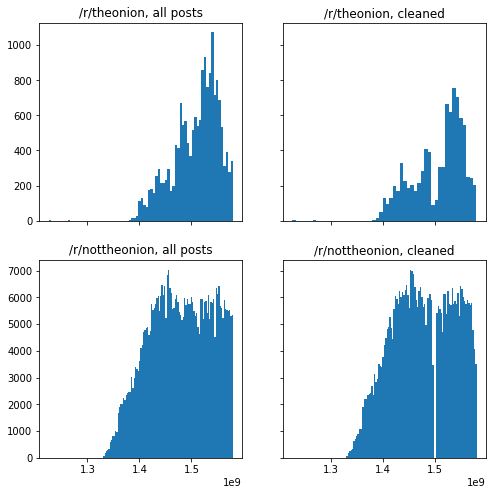

In [55]:
fig, axes = plt.subplots(2,2, figsize=(8,8), sharex=True, sharey="row")
axes = axes.ravel()
axes[0].hist(X_theonion_orig["created_utc"], bins='auto');
axes[1].hist(X_theonion["created_utc"], bins='auto');
axes[2].hist(X_nottheonion_orig["created_utc"], bins='auto');
axes[3].hist(X_nottheonion["created_utc"], bins='auto');

axes[0].set_title('/r/theonion, all posts');
axes[1].set_title('/r/theonion, cleaned');
axes[2].set_title('/r/nottheonion, all posts');
axes[3].set_title('/r/nottheonion, cleaned');

In [56]:
X_nottheonion

,title,score,created_utc,len,word_len
0,White Supremacists For Obama True!,9,1225757362,34,5
1,How The Hair In My Drain Is Like The Curve Of ...,1,1249259207,73,14
3,"Caldwell May Pull Manning In The 2nd Half, Nee...",1,1265573050,98,19
4,Dr Dre To Release Instrumental Hip-Hop Album A...,3,1280960689,67,11
5,Religious Search Engines Yield Tailored Result...,5,1284411997,53,8
...,...,...,...,...,...
422335,Arizona Man Dresses Up Fake Skeleton To Drive ...,1,1579981771,57,11
422336,TikTok Teens Are Dipping Their Balls In Soy Sa...,1,1579981998,83,15
422337,"Virginia Man Sues Local Paper, Reporter For Ac...",1,1579982317,98,13
422338,Saudi Millionaire Who Said He 'accidentally Tr...,1,1579983165,96,14


In [57]:
len(X_nottheonion)

419204

### `/r/onionheadlines`
We will defer attempts to classify onionheadlines to a future date.

## Data inspection / feature engineering

### Post length (words/characters)

In [58]:
dflist = [X_theonion, X_nottheonion]

In [59]:
X_theonion.loc[:, ["len", "word_len"]].describe()

,len,word_len
count,8588.000000,8588.000000
mean,71.032837,11.401723
std,24.524116,3.958885
min,15.000000,4.000000
25%,53.000000,8.000000
50%,71.000000,11.000000
75%,88.000000,14.000000
max,243.000000,37.000000


In [60]:
X_nottheonion.loc[:, ["len", "word_len"]].describe()

,len,word_len
count,419204.000000,419204.000000
mean,69.292657,11.326001
std,24.786400,4.217066
min,5.000000,3.000000
25%,54.000000,9.000000
50%,66.000000,11.000000
75%,80.000000,13.000000
max,305.000000,63.000000


Checking out the really long titles:

In [61]:
with pd.option_context("display.max_colwidth", -1, "display.max_rows", 20):
    display(X_theonion[X_theonion["word_len"]>20])

,title,score,created_utc,len,word_len
id,,,,,
24hlnt,George W. Bush Chuckles To Self Upon Thinking About How He Was President Of The United States For Almost A Decade,3,1398978992,113,21
2hcutn,"Man Just Going To Grab Guitar And Old Four-Track, Go Out To Cabin In Woods, Make Shittiest Album Anyones Ever Heard",73,1411585615,115,21
2jan73,There Were Just 2 Ways Out Of My Neighborhood: Basketball Or Anything Else You Wanted To Do With Your Life,29,1413353675,107,21
2wobgh,"Report: Majority Of Mothers Would Drop Kids Off At Warehouse Called Fun Zone For Hour Of Free Time, No Questions Asked",23,1424542203,118,21
3dla9r,"Well, Folks, It Appears Some Shithead Down There Is Shining A Laser Pointer Into The Cockpit And Were About To Crash",76,1437108252,116,21
...,...,...,...,...,...
ea63fa,"Well Spoken, My Good Fellow, But Let Me Retort, Says Congressman Engaged In Probing, High-Minded Debate On Facts And Merits Of Impeachment",1,1576254198,138,22
ebl5lh,And Then Those 12 People Send It To 12 People—Thats 144 People!” Says Cory Booker Describing Campaign Newsletter Strategy To Rosario Dawson,1,1576530259,139,22
eio2qk,So People Could Be Listening To This Conversation Right Now? Asks Joe Rogan Trying To Understand Edward Snowdens Explanation Of Surveillance,1,1577914075,140,21


In [62]:
with pd.option_context("display.max_colwidth", -1, "display.max_rows", 20):
    display(X_nottheonion[X_nottheonion["word_len"]>35])

,title,score,created_utc,len,word_len
156,Swede Tweets Cops To Enforce Speeding Laws On Road; Police Respond By Patrolling Road The Next Day. Swede Promptly Gets Caught Speeding On Section Of Road He Reported The Previous Day; Promptly Admits To Idiotic Mistake. :,47,1333726134,222,37
178,"Pigeons Could Poop Soap, Thanks To A Special Diet - A Plan To Alter What Pigeons Eat To Turn Their Feces Into Soap, To Clean Up Buildings &amp; Car Windshields Raises Ethical, Legal &amp; Practical Questions",78,1334110806,207,36
196,"Now You Can Smell Like Fake Whale Vomit - Finally, Thanks To Modern Science, You No Longer Have To Feed A Whale A Bathing Suit Full Of Rotten Fish To Get A Supply Of Precious Ambergris, The Whale-Vomit-Derived Material Used In Perfumes",50,1334318627,235,42
243,"A Cloud Of Pot Busts Lingers Over College Football. \nWhen Brandon Arrived At Michigan In 2010 After \nserving As The CEO Of Domino's Pizza For 11 Years, \nhe Says He Was Surprised To Learn How Infrequently \nthe Wolverines Were Actually Tested",6,1334790183,240,41
281,"Job Security: Fargo ND Police. You Can A. Have Sex With A Teenager In Your Squad Car And B. Leave Your Squad Car Unlocked, Allowing A Thief To Steal Handcuffs, Taser, Ammo And Bulletproof Vest And Not Endanger Your Job At All.",46,1335296980,228,44
...,...,...,...,...,...
420876,"The Govt Says All Traffic Lights Broken By Protesters Are Now Fixed, Apart From A Few Components That Need To Be Replaced. But It Appears By ""components"", It Means The Actual Lights That Tell Drivers And Pedestrians Whether They Can Go Or Not. #HongKong News.rthk.hk/rthk/en/compon…",1,1579167002,282,45
421045,Lev Parnas Threatens To Release New Incriminating Evidence Every Time Trump Claims Not To Know Him - “I Welcome Him To Say That Even More. Every Time He Says That I’ll Show Him Another Picture. He’s Lying.”,1,1579244842,206,37
421537,"""You Talk About Action On Climate Change, That’s What That Is. Hazard Reduction Is Action To Take Account Of The Climate We’re Living In, Which Is A More Challenging Environment Over The Next Decade And Beyond,"" Mr Morrison Australia's Prime Minister Said.",1,1579602425,256,42
421599,"Uganda's Tiny Indian Community Accounted For 90% Of Its Tax Revenues Before Being Expelled In 1972. They Were Permitted To Return In The 1980s, And Today Despite Being Only 1% Of The Population Account For 65% Of Uganda's Tax Revenues.",1,1579630924,235,40


### Date of posts
This section is last because it is the last thing I thought to investigate; I had to retroactively go back and ensure that the cleaning I was doing wasn't indiscriminately wiping out entire epochs of posts (spoiler: it was, and I had to fix that).

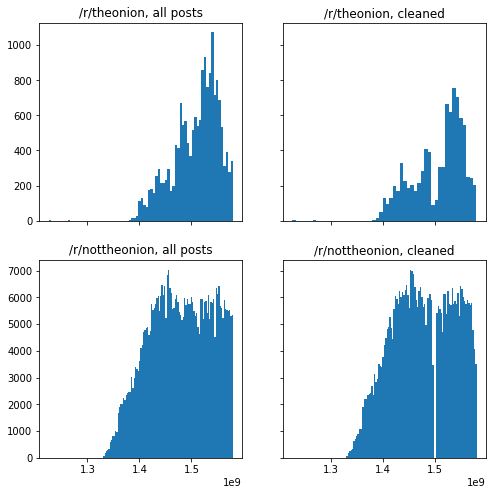

In [63]:
fig, axes = plt.subplots(2,2, figsize=(8,8), sharex=True, sharey="row")
axes = axes.ravel()
axes[0].hist(X_theonion_orig["created_utc"], bins='auto');
axes[1].hist(X_theonion["created_utc"], bins='auto');
axes[2].hist(X_nottheonion_orig["created_utc"], bins='auto');
axes[3].hist(X_nottheonion["created_utc"], bins='auto');

axes[0].set_title('/r/theonion, all posts');
axes[1].set_title('/r/theonion, cleaned');
axes[2].set_title('/r/nottheonion, all posts');
axes[3].set_title('/r/nottheonion, cleaned');

# Write our cleaned DataFrames to pickle files

In [64]:
save_obj(X_theonion, DIR+FILE1+"_df_clean")

In [65]:
save_obj(X_nottheonion, DIR+FILE2+"_df_clean")